In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import pickle
import pandas as pd

In [2]:
from keras.preprocessing import image, sequence
from keras.applications import VGG16
from keras.layers import Dense, Convolution2D, Dropout, LSTM, TimeDistributed, Embedding, Bidirectional, Activation, RepeatVector, Merge
from keras.models import Sequential, Model
from keras.optimizers import Nadam

Using Theano backend.
Using cuDNN version 5110 on context None
Mapped name None to device cuda: GeForce GTX 1060 6GB (0000:01:00.0)


In [3]:
images_dir = os.listdir("./Flickr8k_Dataset/Flicker8k_Dataset/")

images_path = './Flickr8k_Dataset/Flicker8k_Dataset/'
captions_path = './Flickr8k_text/Flickr8k.token.txt'
train_path = './Flickr8k_text/Flickr_8k.trainImages.txt'
val_path = './Flickr8k_text/Flickr_8k.devImages.txt'

captions = open(captions_path, 'r').read().split("\n")
x_train = open(train_path, 'r').read().split("\n")
x_test = open(val_path, 'r').read().split("\n")

In [4]:
tokens = {}

for ix in range(len(captions)):
    temp = captions[ix].split("#")
    if temp[0] in tokens:
        tokens[temp[0]].append(temp[1][2:])
    else:
        tokens[temp[0]] = [temp[1][2:]]

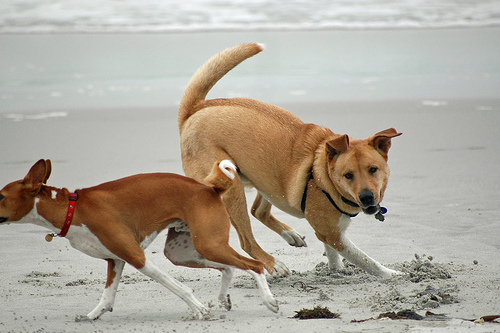

['Two different breeds of brown and white dogs play on the beach .', 'Two dogs are making a turn on a soft sand beach .', 'Two dogs playing in the sand at the beach .', 'Two dogs playing together on a beach .', 'Two large tan dogs play along a sandy beach .']


In [5]:
temp = captions[100].split("#")
from IPython.display import Image, display
z = Image(filename=images_path+temp[0])
display(z)

for ix in range(len(tokens[temp[0]])):
    print tokens[temp[0]][ix]

In [6]:
print "Number of Training Images {}".format(len(x_train))

Number of Training Images 6000


In [7]:
vgg = VGG16(weights='imagenet', include_top=True, input_shape=(224,224,3))

In [8]:
def preprocess_input(img):
    img = img[:, :, :, ::-1] #RGB to BGR
    img[:, :, :, 0] -= 103.939 
    img[:, :, :, 1] -= 116.779
    img[:, :, :, 2] -= 123.68
    return img

In [9]:
def preprocessing(img_path):
    im = image.load_img(img_path, target_size=(224,224,3))
    im = image.img_to_array(im)
    im = np.expand_dims(im, axis=0)
    im = preprocess_input(im)
    return im

In [10]:
x = preprocessing(images_path+temp[0])
print x.shape

(1L, 224L, 224L, 3L)


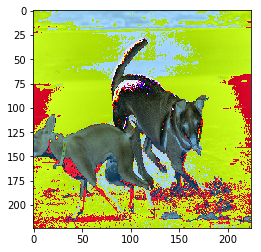

In [11]:
plt.figure(0)
plt.imshow(np.squeeze(x, axis=0))
plt.show()

In [12]:
vgg.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [13]:
vgg = Model(inputs=vgg.input, outputs=vgg.layers[-2].output)

In [14]:
vgg.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

# Encoding Images using VGG #

In [15]:
def get_encoding(model, img):
    image = preprocessing(images_path+img)
    pred = model.predict(image)
    pred = np.reshape(pred, pred.shape[1])
    return pred

In [16]:
print temp[0]

print get_encoding(vgg, temp[0]).shape

1024138940_f1fefbdce1.jpg
(4096L,)


In [17]:
train_dataset = open('./Flickr8k_text/flickr_8k_train_dataset.txt','wb')
train_dataset.write("image_id\tcaptions\n")

val_dataset = open('Flickr8k_text/flickr_8k_val_dataset.txt','wb')
val_dataset.write("image_id\tcaptions\n")

In [18]:
train_encoded_images = {}

c_train = 0
for img in x_train:
    train_encoded_images[img] = get_encoding(vgg, img)
    for capt in tokens[img]:
        caption = "<start> "+ capt + " <end>"
        train_dataset.write(img+"\t"+caption+"\n")
        train_dataset.flush()
        c_train += 1
train_dataset.close()

In [19]:
test_encoded_images = {}

c_test = 0
for img in x_test:
    test_encoded_images[img] = get_encoding(vgg, img)
    for capt in tokens[img]:
        caption = "<start> "+ capt + " <end>"
        val_dataset.write(img+"\t"+caption+"\n")
        val_dataset.flush()
        c_test += 1
val_dataset.close()

In [20]:
with open( "train_encoded_images.p", "wb" ) as pickle_f:
    pickle.dump(train_encoded_images, pickle_f )  
    
with open( "test_encoded_images.p", "wb" ) as pickle_f:
    pickle.dump(test_encoded_images, pickle_f )  

# Building Vocabulary #

In [21]:
pd_dataset = pd.read_csv("./Flickr8k_text/flickr_8k_train_dataset.txt", delimiter='\t')
ds = pd_dataset.values
print ds.shape

(30000L, 2L)


In [22]:
sentences = []
for ix in range(ds.shape[0]):
    sentences.append(ds[ix, 1])
    
print len(sentences)

30000


In [23]:
words = [i.split() for i in sentences]

In [24]:
print words[0]
print len(words)

['<start>', 'A', 'black', 'dog', 'is', 'running', 'after', 'a', 'white', 'dog', 'in', 'the', 'snow', '.', '<end>']
30000


In [25]:
unique = []
for i in words:
    unique.extend(i)

In [26]:
print unique[:3]

['<start>', 'A', 'black']


In [27]:
print len(unique)

413377


In [28]:
unique = list(set(unique))
print len(unique)

vocab_size = len(unique)

8253


In [29]:
#Vectorization
word_2_indices = {val:index for index, val in enumerate(unique)}
indices_2_word = {index:val for index, val in enumerate(unique)}

In [30]:
print word_2_indices['<start>']
print indices_2_word[4011]

4011
<start>


In [31]:
max_len = 0

for i in sentences:
    i = i.split()
    if len(i) > max_len:
        max_len = len(i)

print max_len

40


# Creating Padded Sequences and Next Words #

In [32]:
padded_sequences, subsequent_words = [], []

for ix in range(ds.shape[0]):
    partial_seqs = []
    next_words = []
    text = ds[ix, 1].split()
    text = [word_2_indices[i] for i in text]
    for i in range(1, len(text)):
        partial_seqs.append(text[:i])
        next_words.append(text[i])
    padded_partial_seqs = sequence.pad_sequences(partial_seqs, max_len, padding='post')

    next_words_1hot = np.zeros([len(next_words), vocab_size], dtype=np.bool)
    
    #Vectorization
    for i,next_word in enumerate(next_words):
        next_words_1hot[i, next_word] = 1
        
    padded_sequences.append(padded_partial_seqs)
    subsequent_words.append(next_words_1hot)
    
padded_sequences = np.asarray(padded_sequences)
subsequent_words = np.asarray(subsequent_words)

print padded_sequences.shape
print subsequent_words.shape

(30000L,)
(30000L,)


In [33]:
print padded_sequences[0]

[[4011    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0]
 [4011  109    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0]
 [4011  109 4880    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0]
 [4011  109 4880 4332    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0]
 [4011  109 4880 4332 4427    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0  

In [34]:
for ix in range(len(padded_sequences[0])):
    for iy in range(max_len):
        print indices_2_word[padded_sequences[0][ix][iy]],
    print "\n"

print len(padded_sequences[0])

<start> raining raining raining raining raining raining raining raining raining raining raining raining raining raining raining raining raining raining raining raining raining raining raining raining raining raining raining raining raining raining raining raining raining raining raining raining raining raining raining 

<start> A raining raining raining raining raining raining raining raining raining raining raining raining raining raining raining raining raining raining raining raining raining raining raining raining raining raining raining raining raining raining raining raining raining raining raining raining raining raining 

<start> A black raining raining raining raining raining raining raining raining raining raining raining raining raining raining raining raining raining raining raining raining raining raining raining raining raining raining raining raining raining raining raining raining raining raining raining raining raining 

<start> A black dog raining raining raining rain

In [37]:
with open('./train_encoded_images.p', 'rb') as f:
        encoded_images = pickle.load(f)

In [38]:
imgs = []

for ix in range(ds.shape[0]):
    imgs.append(encoded_images[ds[ix, 0]])

imgs = np.asarray(imgs)
print imgs.shape

(30000L, 4096L)


In [39]:
number_of_images = 1500 

In [40]:
captions = np.zeros([0, max_len])
next_words = np.zeros([0, vocab_size])

for ix in range(number_of_images):#img_to_padded_seqs.shape[0]):
    captions = np.concatenate([captions, padded_sequences[ix]])
    next_words = np.concatenate([next_words, subsequent_words[ix]])

np.save("./captions.npy", captions)
np.save("./next_words.npy", next_words)

print captions.shape
print next_words.shape

(19136L, 40L)
(19136L, 8253L)


In [41]:
images = []

for ix in range(number_of_images):
    for iy in range(padded_sequences[ix].shape[0]):
        images.append(imgs[ix])
        
images = np.asarray(images)

np.save("./images.npy", images)

print images.shape

(19136L, 4096L)


In [42]:
image_names = []

for ix in range(number_of_images):
    for iy in range(padded_sequences[ix].shape[0]):
        image_names.append(ds[ix, 0])
        
image_names = np.asarray(image_names)

np.save("./image_names.npy", image_names)

print len(image_names)

19136
